# Imports

In [ ]:
from GammatoneFilter import GammatoneFilterbank
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import convolve
import soundfile as sf
import IPython.display as ipd

# Example Usage (Gammatone)

In [8]:
num_filters = 10
sample_rate = 16000
low_freq = np.finfo(float).eps
high_freq = sample_rate // 2
num_fft = 512

In [9]:
gfb = GammatoneFilterbank(
    num_filters=num_filters,
    sample_rate=sample_rate,
    low_freq=low_freq,
    high_freq=high_freq,
    num_fft=num_fft,
    with_inverse=True
    )

In [10]:
time_domain_filters = gfb.filters
N = gfb.num_filters
fs = gfb.sample_rate
nfft = gfb.num_fft

print(f'Number of filters: {N*2}')
# Split out the normal vs. inverted sets (10 first are normal, 10 last are inverted)
normal_filters = time_domain_filters[:N]
inverted_filters = time_domain_filters[N:]

print("Number of normal filters: ", normal_filters.shape[0])
print("Number of inverted filters: ", inverted_filters.shape[0])

# Prepare frequency axis 0..fs (for the 'whole' FFT)
freq_axis = np.linspace(0, fs, nfft, endpoint=False)

# Compute the magnitude response in dB for each filter
def compute_dB_responses(filters):
    # filters shape (N, nfft) in the time domain
    Nch = filters.shape[0]
    mag_db = np.zeros_like(filters, dtype=float)
    for i in range(Nch):
        Hf = np.fft.fft(filters[i, :], n=nfft)
        # Avoid log(0) by adding a tiny epsilon
        mag_db[i, :] = 20.0 * np.log10(np.abs(Hf) + np.finfo(float).eps)
    return mag_db


Number of filters: 20
Number of normal filters:  10
Number of inverted filters:  10


In [ ]:
MATLAB_INV_FILTERS_FILE = "/Users/guyperets/Documents/MSc/ASVspoof_PMF-2d_quantization/matlab/filters/gammatone/filters_inv.mat"
MATLAB_FILTERS_FILE = "/Users/guyperets/Documents/MSc/ASVspoof_PMF-2d_quantization/matlab/filters/gammatone/filters.mat"
matlab_inv_filters = loadmat(MATLAB_INV_FILTERS_FILE)
matlab_filters = loadmat(MATLAB_FILTERS_FILE)
matlab_filt = matlab_filters['filters']
matlab_inv_filt = matlab_inv_filters['filters']

In [ ]:
assert np.allclose(np.abs(matlab_filt - normal_filters), 0.0, atol=1e-7), "MATLAB and Python filters do not match"
assert np.allclose(np.abs(matlab_inv_filt - inverted_filters), 0.0, atol=1e-7), "MATLAB and Python inverted filters do not match"

AssertionError: MATLAB and Python filters do not match

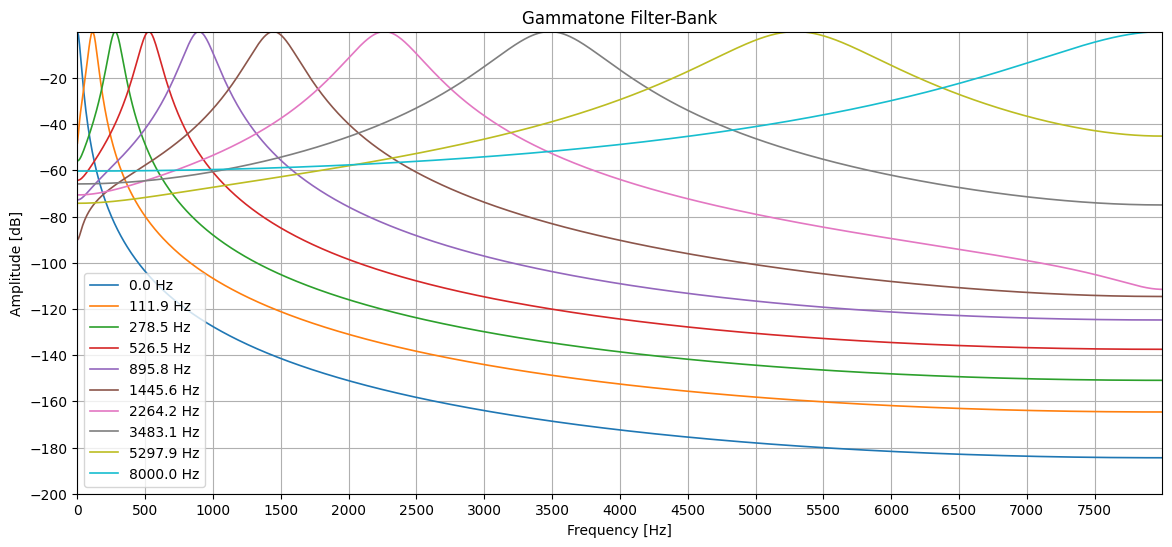

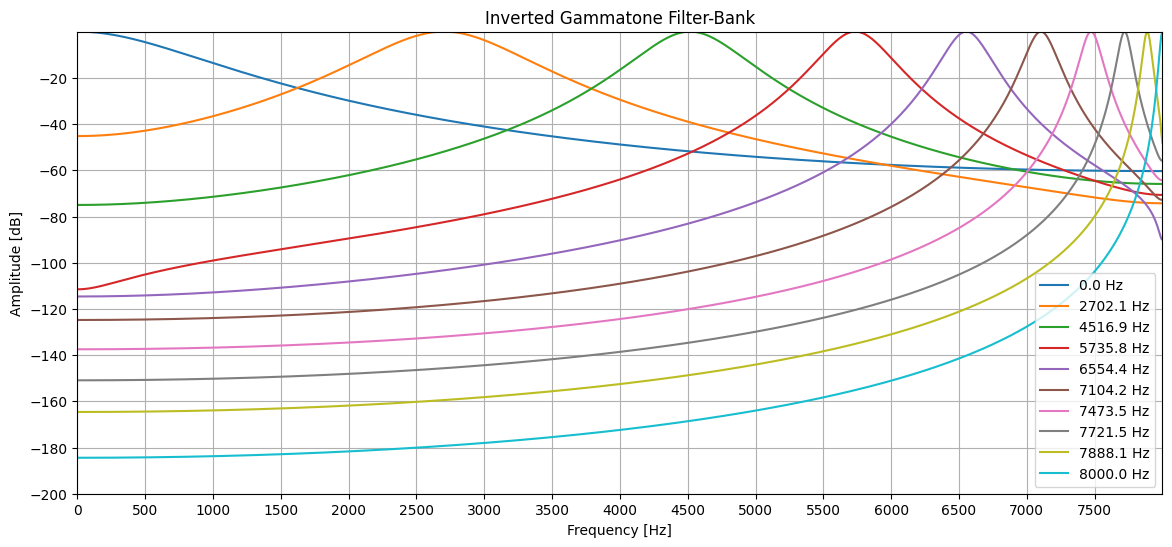

In [7]:
H_normal_dB   = compute_dB_responses(normal_filters)
H_inverted_dB = compute_dB_responses(inverted_filters)

# Plot Normal
plt.figure(figsize=(14, 6))

sorted_idx = np.argsort(gfb.center_freqs)

# PLOT IN SORTED ORDER SO COLORS & LABELS LINE UP AUTOMATICALLY
for i in sorted_idx:
    plt.plot(freq_axis, H_normal_dB[i, :], linewidth=1.2, label=f'{gfb.all_center_freqs[i]:.1f} Hz')
plt.title("Gammatone Filter-Bank")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [dB]")
plt.ylim([-200, 0])          # match your desired dB range
plt.xlim([0, fs/2])          # plot only up to Nyquist if desired
plt.xticks(np.arange(0, fs/2, 500))
plt.yticks(np.arange(-200, 0, 20))
plt.legend()
plt.grid(True)

# Plot Inverted
plt.figure(figsize=(14, 6))
sorted_inv_idx = np.argsort(gfb.inverted_center_freqs)

for i in sorted_inv_idx:
    plt.plot(freq_axis, H_inverted_dB[i, :], label=f'{gfb.all_center_freqs[N + i]:.1f} Hz')
plt.title("Inverted Gammatone Filter-Bank")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [dB]")
plt.ylim([-200, 0])
plt.xlim([0, fs/2])
plt.xticks(np.arange(0, fs/2, 500))
plt.yticks(np.arange(-200, 0, 20))
plt.legend()
plt.grid(True)

plt.show()

# Example Of Filtering

In [ ]:
center_freqs = gfb.all_center_freqs

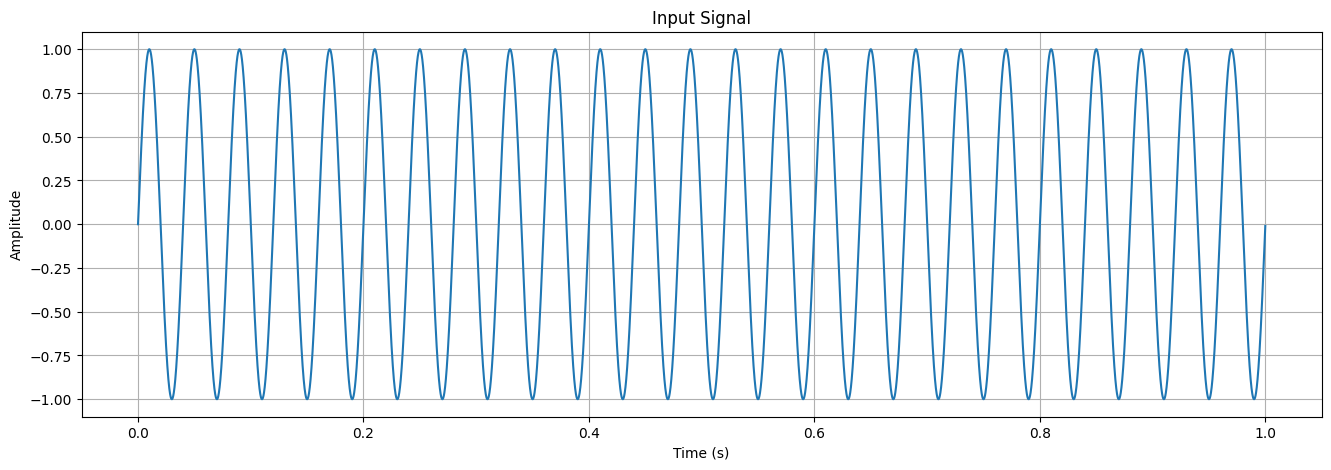

In [9]:
# Example filtering with the first filter

# Create a sample sinosidal signal
duration = 1  # seconds
frequency = 25  # Hz
sample_rate = 16000
t = np.linspace(0, duration, sample_rate * duration, endpoint=False)
signal = np.sin(2 * np.pi * frequency * t)

# Plot
plt.figure(figsize=(16, 5))
plt.plot(t, signal)
plt.title('Input Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [ ]:
def filter_signal(signal, filt, plot=False):
    """
    Filters a signal with a given impulse response and optionally plots the result.

    Parameters:
    -----------
    signal : array_like
        The input signal (1D array).
    filt : array_like
        The filter impulse response (1D array), e.g., one filter from the filterbank.
    plot : bool, optional
        If True, the function will plot the original and filtered signals.
    
    Returns:
    --------
    filtered_signal : ndarray
        The filtered signal.
    """
    signal = np.asarray(signal)
    filt = np.asarray(filt)
    
    # Ensure that both are 1D arrays by "squeezing" out singleton dimensions.
    # This will convert shapes like (N, 1) or (1, N) to (N,).
    signal = np.squeeze(signal)
    filt = np.squeeze(filt)
    
    # Check if the resulting arrays are indeed 1D. If not, raise an error.
    if signal.ndim != 1:
        raise ValueError("The input signal must be one-dimensional after squeezing.")
    if filt.ndim != 1:
        raise ValueError("The filter must be one-dimensional after squeezing.")

    # Perform convolution to filter the signal.
    # We use mode='same' so that the output signal has the same length as the input.
    filtered_signal = convolve(signal, filt, mode='same')
    filtered_signal = filtered_signal / np.max(np.abs(filtered_signal))  # ? Normalize the output
    
    # If plotting is requested, display the original and filtered signals.
    if plot:
        plt.figure(figsize=(16, 5))
        plt.plot(signal, label='Original Signal', linewidth=2)
        plt.plot(filtered_signal, label='Filtered Signal', linestyle='--', linewidth=2)
        plt.title('Original vs. Filtered Signal')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return filtered_signal


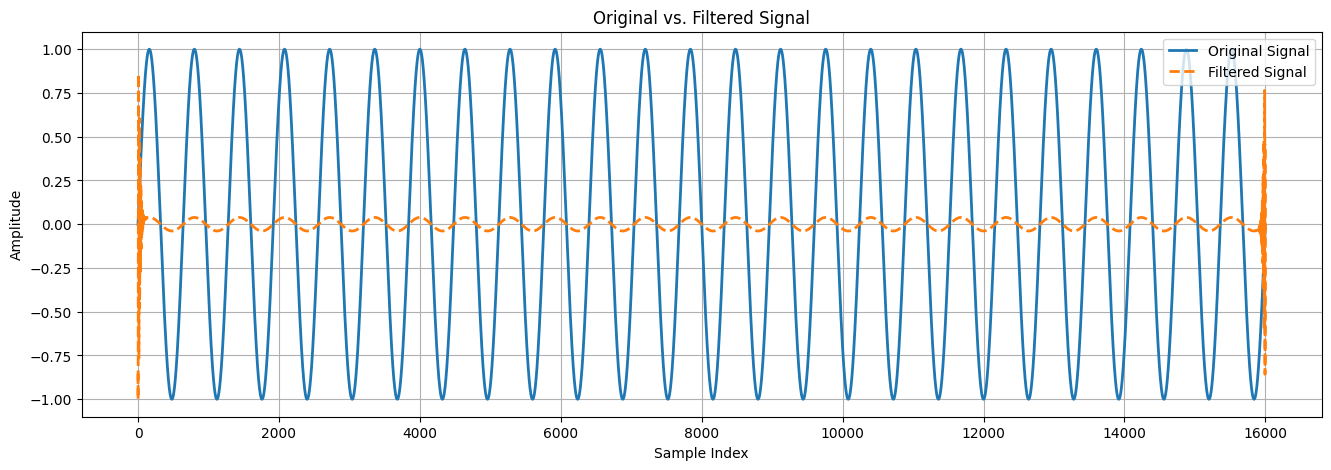

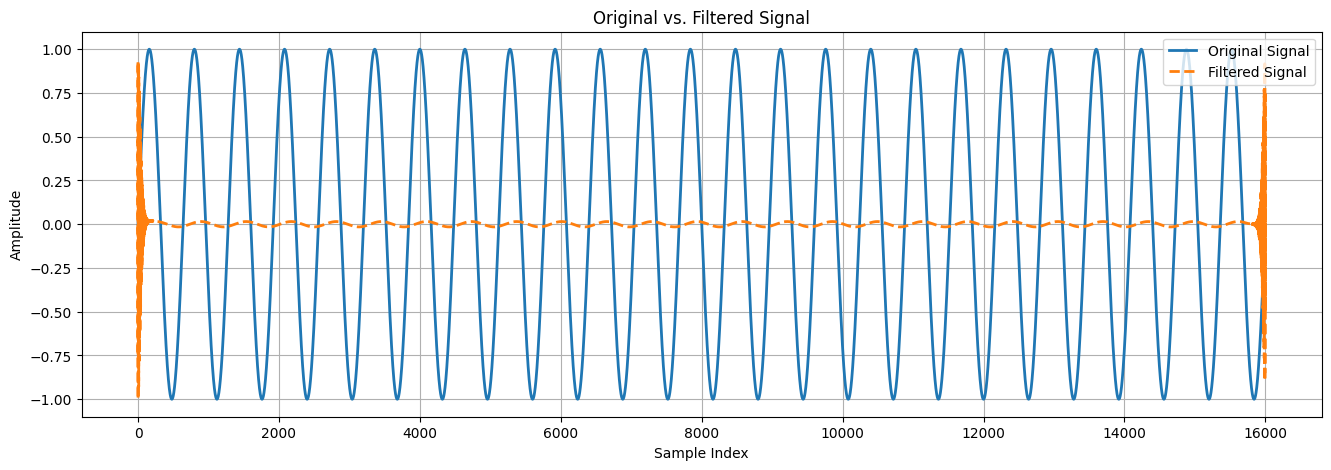

In [25]:
filtered_normal = filter_signal(signal, normal_filters[0], plot=True)
filtered_inverted = filter_signal(signal, inverted_filters[-1], plot=True)

# Hear The Filtered Signals

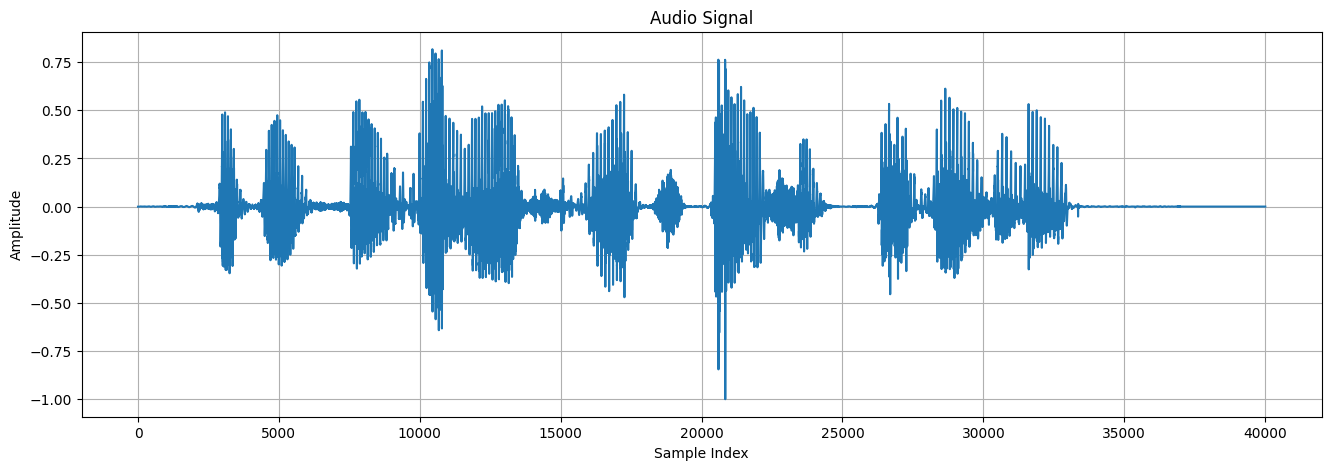

In [ ]:
# Load sample audio file
FILE_PATH = '/Users/guyperets/Documents/MSc/Datasets/ASVSpoof2019/LA/ASVspoof2019_LA_train/flac/LA_T_1000137.flac'

# Load the audio file
audio, sample_rate = sf.read(FILE_PATH)

# Plot the audio signal
plt.figure(figsize=(16, 5))
plt.plot(audio)
plt.title('Audio Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()
ipd.Audio(audio, rate=sample_rate)

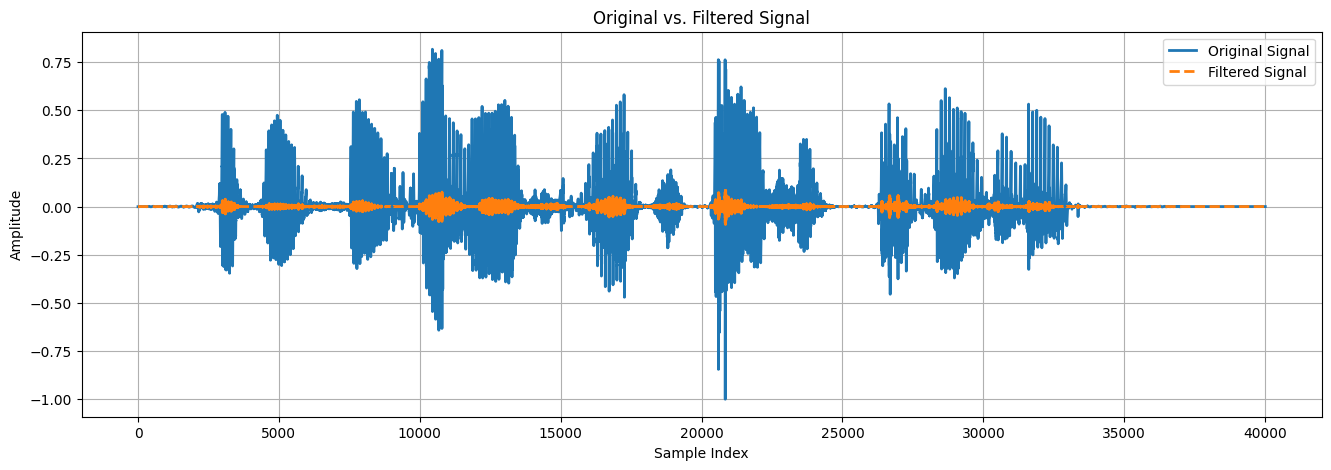

/Users/guyperets/.pyenv/versions/3.12.9/envs/MSc/lib/python3.12/site-packages/IPython/lib/display.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


In [29]:
# Now we can filter the audio signal with the first filter from the filterbank
normal_filtered_audio = filter_signal(audio, normal_filters[7], plot=True)
# Play the filtered audio
ipd.Audio(normal_filtered_audio, rate=sample_rate)

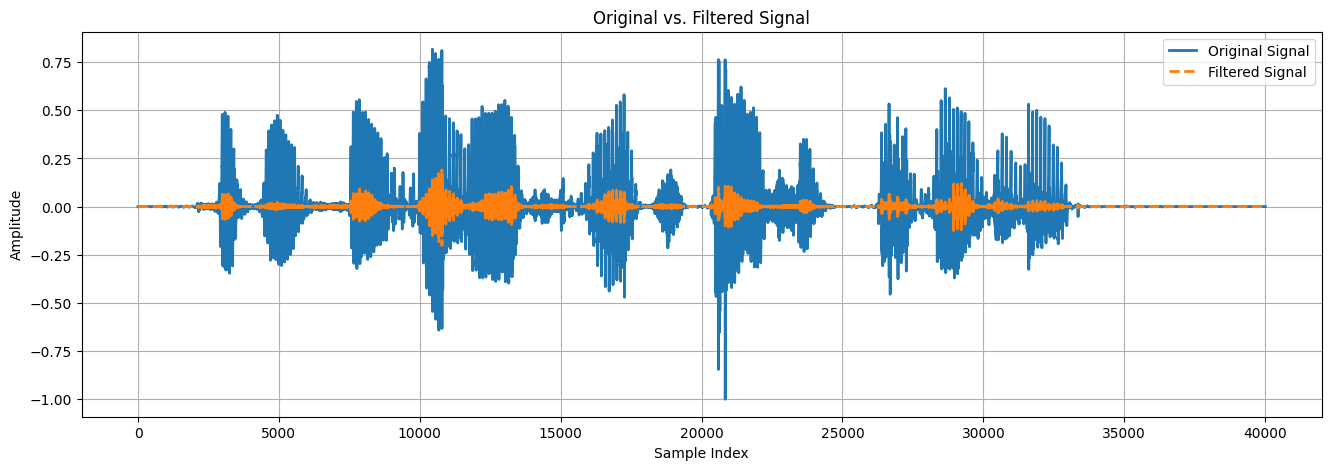

In [30]:
inverted_filtered_audio = filter_signal(audio, inverted_filters[-2], plot=True)
# Play the filtered audio
ipd.Audio(inverted_filtered_audio, rate=sample_rate)

In [31]:
# Add both filtered signals and play the result
mixed_audio = normal_filtered_audio + inverted_filtered_audio
ipd.Audio(mixed_audio, rate=sample_rate)